# DEA WOfS and Water Classifier Notebook 

**Description:** This notebook allows users to perform water classification. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOfS) algorithm. 

The outputs of the WOfS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts.

__Before you run this notebook:__ This notebook uses the dea module. You need to run "module load dea" in a terminal window and then launch jupyter notebooks in the same window so that your notebook can 'see' the dea module.

This notebook is based on a CEOS [notebook](https://github.com/ceos-seo/data_cube_notebooks/blob/master/water_detection.ipynb) 

The water classifier is based on [Mueller, et al. (2015)](## References) [github link to water classifier code](https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py)

__Date:__ May 2018

__Authors:__ Erin Telfer, Bex Dunn


## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [17]:
%pylab notebook

from matplotlib import pyplot as plt
import numpy as np
import os
import warnings
import xarray as xr

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-WOfS and water classifier')

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEADataHandling, water_classifier_and_wofs

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

Populating the interactive namespace from numpy and matplotlib


## edit query and extract data from DEA
User input: define details below

In [3]:
#Use this to manually define an upper left/lower right coords
lat_max = -12.4 #
lat_min = -12.7
lon_max = 135.2
lon_min = 134.9 

#define temporal range
start_of_epoch = '2016-01-01'
end_of_epoch =  '2016-05-01'

#define Landsat sensors of interest
sensors = ['ls8','ls7','ls5'] 

In [4]:
#Query is created
query = {'time': (start_of_epoch, end_of_epoch),}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print (query)

{'time': ('2016-01-01', '2016-05-01'), 'x': (134.9, 135.2), 'y': (-12.4, -12.7), 'crs': 'EPSG:4326'}


In [5]:
#using the load function from DEADataHandling to get the data and filter
nbart = DEADataHandling.load_clearlandsat(dc, query, product='nbar', masked_prop=0, mask_dict={'cloud_acca': 'no_cloud', 'cloud_fmask': 'no_cloud', 'cloud_shadow_acca':'no_cloud_shadow','cloud_shadow_fmask':'no_cloud_shadow','blue_saturated':False,'green_saturated':False,'red_saturated':False,'nir_saturated':False,'swir1_saturated':False,'swir2_saturated':False})

Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 8 filtered ls7 timesteps
Loading ls8 PQ
    Loading 8 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


## Classify water and calculate Water Observations from Space (WOfS)

In [7]:
#Use water clasifier function 
warnings.filterwarnings('ignore') #turn off warnings
water_class = water_classifier_and_wofs.water_classifier(nbart)#_subset) #use function
warnings.filterwarnings('always') #turn on warnings
print(water_class)

<xarray.Dataset>
Dimensions:  (time: 16, x: 1358, y: 1337)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T01:04:21 ...
  * y        (y) float64 -1.311e+06 -1.311e+06 -1.311e+06 -1.311e+06 ...
  * x        (x) float64 3.203e+05 3.203e+05 3.204e+05 3.204e+05 3.204e+05 ...
Data variables:
    wofs     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


## Calculate and plot WOfS

In [8]:
#note, this is using only one band for the count, and this isn't robust.

total_water_obs = water_class.wofs.sum(dim='time')
nbar_count = nbart.blue.count(dim='time')
wofs = ((total_water_obs/nbar_count)*100)

In [9]:
#Set up colour ramp details to meet DEA specified colour details
# wofs_cmap = mpl.colors.ListedColormap(['#000000', '#8e0101', '#cf2200', '#e38400',
#                                        '#e3df00', '#a6e300', '#62e300', '#00e32d',
#                                        '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
#                                        '#005fe3', '#000fe3', '#5700e3'])
wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                       '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                       '#005fe3', '#000fe3', '#5700e3'])
wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)

<IPython.core.display.Javascript object>


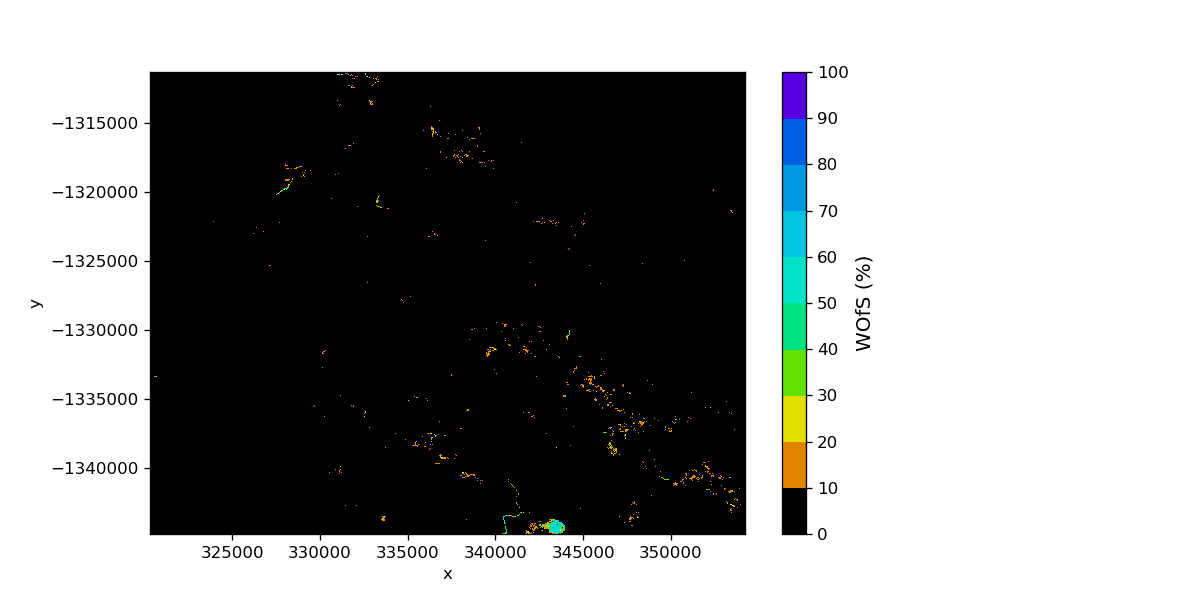

In [10]:
#Create WOfS image with specified colour ramp details
fig = plt.figure(figsize =(10,5)) 
i=wofs.plot.imshow(cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)
plt.colorbar(i, ticks=wofs_bounds, 
            ).set_label(label='WOfS (%)',
             size=12) #Add definable colour bar
fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar

plt.show() #Create image

### Edit save file path to choose where to save your output files

In [11]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save WOfS output to netCDF

In [14]:
DEADataHandling.write_your_netcdf(wofs,'wofs', savefilepath+'wofs_{}_{}'.format(start_of_epoch,end_of_epoch)+'.nc', crs = nbart.crs )

## Save WOfS output to GeoTiff

In [25]:
dataset = wofs.to_dataset(name='wofs')
dataset.attrs['affine']= nbart.affine
dataset.attrs['crs']= nbart.crs
write_geotiff(savefilepath+'wofs_{}_{}'.format(start_of_epoch,end_of_epoch)+'.tif',dataset)

## References

1. Mueller, et al. 2015., *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. https://doi.org/10.1016/j.rse.2015.11.003
